# Setup

In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LeakyReLU

# Function

In [2]:
def get_data():#ฟังก์ชั่นเรียกข้อมูลและจัดการข้อมูลเ้องต้น
    df=pd.read_csv('energydata_complete.csv')
    df['date'] = pd.to_datetime(df['date'])#ทำให้วันที่และเวลาเป็น date time
    df= df.sort_values(['date'])#เรียงลำดับข้อมูล
    df.set_index('date',inplace=True)
    df.drop(['rv1', 'rv2'],axis=1,inplace=True)
    return df

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):#ฟังก์ชั่นสำหรับจัดการข้อมูลให้เป็นแบบ sequence และ จัดการให้มันเอาข้อมูลกี่ในอดีตมาใช้ในการทำนาย
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def split_data(data):#แบ่งข้อมูลtrain,test,forecast
    split_train =int(data.shape[0]*0.6)
    split_test = int(data.shape[0]*(0.6+0.2))
    
    train = data[:split_train]
    test = data[split_train:split_test]
    forecast = data[split_test:]
    
    return train,test,forecast

In [5]:
def get_xy(train,test,forecast):#แยกx,yโดย y คือข้อมูลที่เราจะให้มันทำนายออกมา
    time_steps=1
    train_X, train_y = train.values[:, :-1], train.values[:, -1:]
    train_X=train_X.reshape((train_X.shape[0],time_steps, train_X.shape[1]))
    test_X, test_y = test.values[:, :-1], test.values[:, -1:]
    test_X=test_X.reshape((test_X.shape[0],time_steps, test_X.shape[1]))
    forecast_X,forecast_y = forecast.values[:, :-1], forecast.values[:, -1:]
    forecast_X=forecast_X.reshape((forecast_X.shape[0],time_steps, forecast_X.shape[1]))
    return train_X,train_y,test_X,test_y,forecast_X,forecast_y

In [6]:
def tscv(data,n_split):#ฟังก์ชั่น แบ่งข้อมูลแบบ time series split สำหรับการทำ cross validation
    cv = TimeSeriesSplit(max_train_size=None, n_splits=n_split)
    train_count=[]
    test_count=[]
    i=0
    for train_val, test_val in cv.split(data):#เข้า for loop เพื่อให้มันนับและจำลำดับของข้อมูลแล้วเรียกข้อมูลตามลำดับที่นับไว้
        i=i+1
        train_count.append(len(train_val))
        test_count.append(len(test_val))
    train1, val1 = data[:train_count[0]], data[train_count[0]:train_count[1]]
    train2, val2 = data[:train_count[1]], data[train_count[1]:train_count[2]]
    train3, val3 = data[:train_count[2]], data[train_count[2]:int(len(data))]
    
    return train1,train2,train3,val1,val2,val3

In [7]:
def split_to_predict(train1,train2,train3,val1,val2,val3):#ฟังก์ชั่นสำหรับแบ่ง x,y และเปลี่ยนมิติของข้อมูล x ให้เป็น3มิติ
    cv_train=[train1,train2,train3]
    cv_test=[val1,val2,val3]
    cv_xtrain=[]
    cv_ytrain=[]
    cv_xtest=[]
    cv_ytest=[]
    for i in range(3):
        train_X, train_y = cv_train[i].values[:, :-1], cv_train[i].values[:, -1:]
        cv_xtrain.append(train_X)
        cv_ytrain.append(train_y)
        test_X, test_y = cv_test[i].values[:, :-1], cv_test[i].values[:, -1:]
        cv_xtest.append(test_X)
        cv_ytest.append(test_y)   
    time_steps=1
    for i in range(3):
      cv_xtrain[i]=cv_xtrain[i].reshape((cv_xtrain[i].shape[0],time_steps, cv_xtrain[i].shape[1]))
      cv_xtest[i]=cv_xtest[i].reshape((cv_xtest[i].shape[0],time_steps, cv_xtest[i].shape[1]))
        
    return cv_xtrain,cv_ytrain,cv_xtest,cv_ytest

In [8]:
def loop_model(x_train,y_train,x_test,y_test):
    i=0
    for i in range(len(x_train)):
        model = Sequential()
        model.add(LSTM(32, activation='relu',return_sequences=True, input_shape=(x_train[i].shape[1],x_train[i].shape[2])))
        model.add(Dropout(0.1))
        model.add(LSTM(32, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.summary()
        history = model.fit(x_train[i],y_train[i], epochs=200, batch_size=250, validation_data=(x_test[i],y_test[i]), verbose=1, shuffle=False)
        i=i+1
        if i == int(len(x_train)):
            break
   
     
        
    
    return model,history

In [9]:
def loss_plot(history):
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    

In [10]:
def inverse_scaled(x_test,y_test,yhat):#ฟังก์ชั่นสำหรับอินเวิร์สข้อมูลจากการ scaled ให้กลับมามีค่าเท่าเดิม
    x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
    td=[]
    for i in range(26):#วนลูปเพื่อเรียกข้อมูลให้มีหน้าตาเหมือนที่ก่อน scaled โดยคอลัมน์ต้องเรียงเหมือนกันและใช้ค่าที่ทำนายใส่แทนลงไปในคอลัมน์ของ appliances ช่องแรก
        ts=x_test[::,(i+1)]
        ts=ts.reshape(len(x_test),1)
        td.append(ts)
    inv_yhat=np.hstack((yhat,td[0],td[1],td[2],td[3],td[4],td[5],td[6],td[7],td[8],td[9],td[10],td[11],td[12],td[13],td[14],td[15],td[16],td[17],td[18],td[19],td[20],td[21],td[22],td[23],td[24]))#นำข้อมูลมาเรียงกัน
    inv_yhat = pd.DataFrame(inv_yhat,columns=df.columns)#ทำให้เป็น Dataframe
    inv_yhat = scaler.inverse_transform(inv_yhat)#อินเวิร์สกลับ
    inv_yhat= inv_yhat[::,0]#เอาเฉพาะคอลัมน์แรก
    inv_ytest=np.hstack((y_test,td[0],td[1],td[2],td[3],td[4],td[5],td[6],td[7],td[8],td[9],td[10],td[11],td[12],td[13],td[14],td[15],td[16],td[17],td[18],td[19],td[20],td[21],td[22],td[23],td[24]))
    inv_ytest = pd.DataFrame(inv_ytest,columns=df.columns)
    inv_ytest = scaler.inverse_transform(inv_ytest)
    inv_ytest = inv_ytest[::,0] 
    
    return inv_yhat,inv_ytest   

In [11]:
def error(y_test,y_hat):#คำนวณและแสดงค่า Error
    rmse = np.sqrt(mean_squared_error(y_test,y_hat))
    r2=r2_score(y_test,y_hat)

    return r2,rmse    

In [12]:
def plot_result(inv_yhat,inv_ytest,title):#พล็อตกราฟระหว่างค่าที่ทำนายกับค่าtest
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.plot(inv_yhat,color='r',label='prediction')
    plt.plot(inv_ytest,color='b',label='actual')
    plt.legend()
    plt.show()

In [13]:
def inverse_train(x_train,y_train):   
    x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
    td=[]
    for i in range(26):
        ts=x_train[::,(i+1)]
        ts=ts.reshape(len(x_train),1)
        td.append(ts)
    inv_ytrain=np.hstack((y_train,td[0],td[1],td[2],td[3],td[4],td[5],td[6],td[7],td[8],td[9],td[10],td[11],td[12],td[13],td[14],td[15],td[16],td[17],td[18],td[19],td[20],td[21],td[22],td[23],td[24]))
    inv_ytrain = pd.DataFrame(inv_ytrain,columns=df.columns)
    inv_ytrain = scaler.inverse_transform(inv_ytrain)
    inv_ytrain= inv_ytrain[::,0] 
    
    return inv_ytrain

# Data preprocessing

In [14]:
df=get_data()#เรียกข้อมูล
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)#สเกลข้อมูล
n_out=1
n_in=26
reframed = series_to_supervised(scaled, n_in, n_out,feat_name=df.columns)#จัดการเรียงให้เป็นลำดับใช้อดีตกี่ตัวมาทำนาย
reframed.drop(['lights(t)','T1(t)', 'RH_1(t)', 'T2(t)','RH_2(t)', 'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)','T6(t)', 'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)','RH_9(t)', 'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)','Visibility(t)', 'Tdewpoint(t)'],axis=1,inplace=True)#drop คอมลัมน์ที่ไม่ต้องการ
train,test,forecast=split_data(reframed)#แบ่งข้อมูล
train1,train2,train3,val1,val2,val3=tscv(train,3)#cross validation
cv_xtrain,cv_ytrain,cv_xtest,cv_ytest=split_to_predict(train1,train2,train3,val1,val2,val3)#แบ่ง x,y
train_X,train_y,test_X,test_y,forecast_X,forecast_y=get_xy(train,test,forecast)#แบ่ง x,y
x_train=[cv_xtrain[0],cv_xtrain[1],cv_xtrain[2],train_X]
y_train=[cv_ytrain[0],cv_ytrain[1],cv_ytrain[2],train_y]
x_test=[cv_xtest[0],cv_xtest[1],cv_xtest[2],test_X]
y_test=[cv_ytest[0],cv_ytest[1],cv_ytest[2],test_y]

In [15]:
x_train[3].shape

(11825, 1, 676)

In [16]:
reframed

,Appliances(t-26),lights(t-26),T1(t-26),RH_1(t-26),T2(t-26),RH_2(t-26),T3(t-26),RH_3(t-26),T4(t-26),RH_4(t-26),...,RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
26,0.046729,0.428571,0.327350,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.688828,0.208117,0.651214,0.351554,0.143411,0.831140,0.428571,0.600000,0.473605,0.084112
27,0.046729,0.428571,0.327350,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.686543,0.208117,0.646661,0.349411,0.144961,0.833333,0.428571,0.600000,0.472097,0.084112
28,0.037383,0.428571,0.327350,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.679689,0.208117,0.646661,0.347267,0.146512,0.835526,0.428571,0.600000,0.470588,0.084112
29,0.037383,0.571429,0.327350,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.678547,0.208117,0.642936,0.345123,0.148062,0.837719,0.428571,0.600000,0.469080,0.084112
30,0.046729,0.571429,0.327350,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.676034,0.208117,0.642936,0.342980,0.149612,0.839912,0.428571,0.600000,0.467572,0.093458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,0.336449,0.000000,0.855333,0.569856,0.755997,0.562283,0.957959,0.625798,0.846847,0.735809,...,0.714359,0.864724,0.727580,0.896034,0.602326,0.412281,0.226190,0.335897,0.903469,0.084112
19731,0.252336,0.000000,0.870468,0.587286,0.758074,0.566099,0.938573,0.613803,0.846847,0.742922,...,0.701645,0.864724,0.729443,0.891747,0.602326,0.416667,0.238095,0.348718,0.901961,0.074766
19732,0.214953,0.000000,0.884548,0.581598,0.763266,0.575780,0.921402,0.616919,0.846847,0.754304,...,0.691912,0.864724,0.729443,0.887460,0.602326,0.421053,0.250000,0.361538,0.900452,0.242991
19733,0.224299,0.000000,0.901091,0.575360,0.763266,0.577829,0.913925,0.622683,0.849850,0.764262,...,0.687457,0.864724,0.729443,0.883173,0.602326,0.425439,0.261905,0.374359,0.898944,0.383178


# Train model

In [17]:
model,history=loop_model(x_train,y_train,x_test,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             90752     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 99,105
Trainable params: 99,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
12/12 [==============================] - 0s 38ms/step - loss: 0.0172 - val_loss: 0.0107
Epoch 2/200
12/12 

Epoch 73/200
12/12 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 74/200
12/12 [==============================] - 0s 8ms/step - loss: 0.0103 - val_loss: 0.0077
Epoch 75/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 76/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 77/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 78/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 79/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 80/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 81/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0101
Epoch 82/200
12/12 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0075


24/24 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 26/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 27/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 28/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 29/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 30/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 31/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 32/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 33/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 34/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 35/200


Epoch 107/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 108/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 109/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 110/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 111/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 112/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 113/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 114/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 115/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 116/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0063 - val_los

24/24 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 189/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 190/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 191/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 192/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 193/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 194/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 195/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 196/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 197/200
24/24 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0042
Epoc

Epoch 60/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 61/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 62/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 63/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 64/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 65/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 66/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 67/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 68/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 69/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0054


48/48 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 13/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 14/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0064
Epoch 15/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 16/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 17/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 18/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 19/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 20/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 21/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 22/200


48/48 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 95/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 96/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 97/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 98/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 99/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 100/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 101/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 102/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 103/200
48/48 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 104

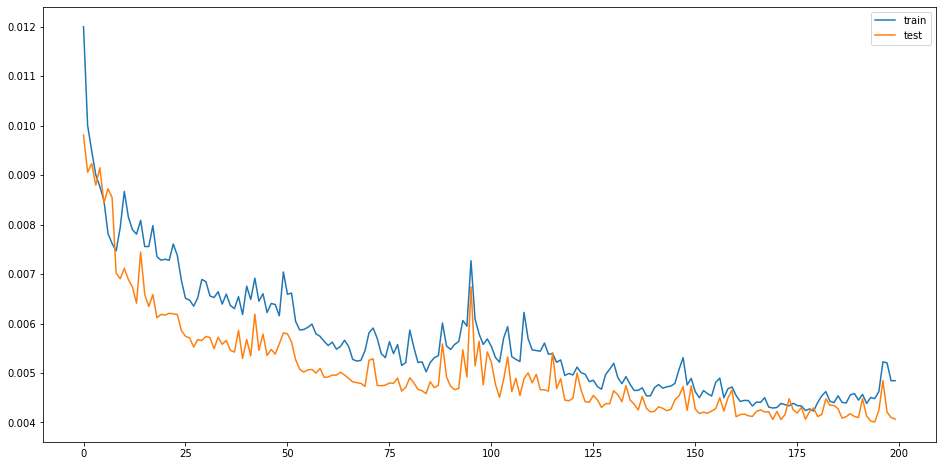

In [18]:
loss_plot(history)

# Forecast

In [19]:
yhat = model.predict(forecast_X) 

In [20]:
inv_yhat_forecast,inv_y_forecast=inverse_scaled(forecast_X,forecast_y,yhat)

In [21]:
r2f,rmsef=error(inv_y_forecast,inv_yhat_forecast)

In [22]:
print('Forecast RMSE Model1: %.3f' % rmsef)
print('Forecast R2-score Model1: %.3f' % r2f)

Forecast RMSE Model1: 64.742
Forecast R2-score Model1: 0.488


In [23]:
inv_ytrain=inverse_train(train_X,train_y)
inv_ytest=inverse_train(test_X,test_y)

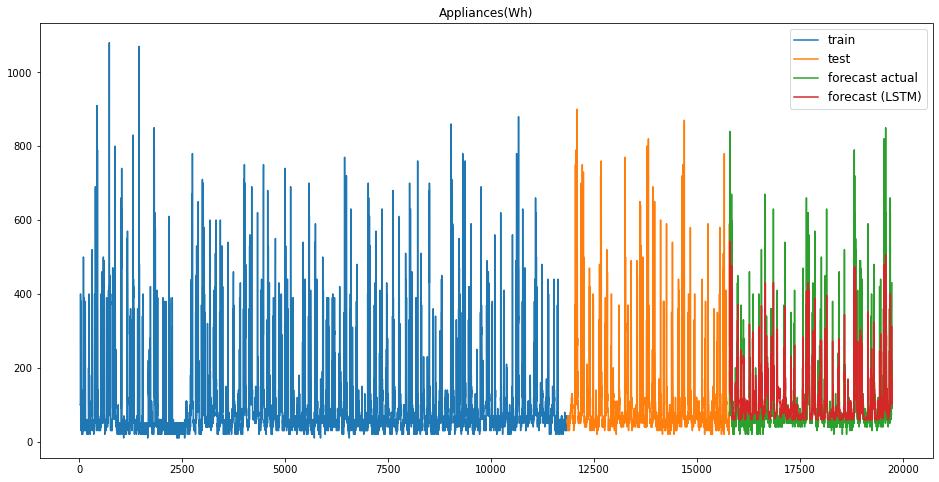

In [24]:
plt.figure(figsize=(16,8))
plt.title('Appliances(Wh)')
plt.plot(train.index,inv_ytrain,label='train')
plt.plot(test.index,inv_ytest,label='test')
plt.plot(forecast.index,inv_y_forecast,label='forecast actual')
plt.plot(forecast.index,inv_yhat_forecast,label='forecast (LSTM)')
plt.legend(fontsize = 'large')
plt.show()